In [46]:
import zipfile
import os
from os import walk
from os.path import join
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
%matplotlib inline

In [2]:
from google.colab import files
uploaded = files.upload()


Saving SpamData.zip to SpamData.zip


In [3]:
zip_file = 'SpamData.zip'
unzip_dir = '/content/DataExtracted'

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)


In [4]:
import os
current_directory = os.getcwd()
print("Current working directory:", current_directory)

Current working directory: /content


**Constants**

In [5]:
EXAMPLE_FILE = 'DataExtracted/SpamData/01_Processing/practice_email.txt'

SPAM_1_PATH = 'DataExtracted/SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'DataExtracted/SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'DataExtracted/SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'DataExtracted/SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0

DATA_JSON_FILE = 'DataExtracted/SpamData/01_Processing/email-text-data.json'

In [54]:
stream = open(EXAMPLE_FILE, encoding='utf-8')
message = stream.read()
stream.close()

print(message)

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

In [55]:
stream = open(EXAMPLE_FILE, encoding='utf-8')
is_body = False
lines = []

for line in stream:
  if is_body:
    lines.append(line)
  elif line == '\n':
    is_body = True

stream.close()
email_body = '\n'.join(lines)

print(email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

**Generator Functions**

In [6]:
def generate_squares(N):
  for my_number in range(N):
    yield my_number ** 2

In [7]:
for i in generate_squares(5):
  print(i, end=' ->')

0 ->1 ->4 ->9 ->16 ->

**Email body extraction**

In [8]:
def email_body_generator(path):

  for root, dirnames, filenames in walk(path):
    for file_name in filenames:

      filepath = join(root, file_name)
      stream = open(filepath, encoding='latin-1')
      is_body = False
      lines = []

      for line in stream:
        if is_body:
          lines.append(line)
        elif line == '\n':
          is_body = True

      stream.close()
      email_body = '\n'.join(lines)

      yield file_name, email_body

In [9]:
def df_from_directory(path,classification):
  rows = []
  row_names = []

  for file_name, email_body in email_body_generator(path):
    rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
    row_names.append(file_name)


  return pd.DataFrame(rows, index=row_names)

In [10]:
spam_emails = df_from_directory(SPAM_1_PATH, 1)
spam_emails = pd.concat([spam_emails, df_from_directory(SPAM_2_PATH, 1)])
spam_emails.head()

,MESSAGE,CATEGORY
00331.a61788d316e7393c8bbf8ee19b24c713,<HTML><HEAD><TITLE></TITLE><META http-equiv=3D...,1
00213.8c42a1c257aa30ff3b3ba668cca59408,<p>We thank you for just a moment of your tim...,1
00438.41295e1df4b651b7611316331b8468e4,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",1
00420.e208f7d65551c01efaa3b4ee4bc4df3c,REGISTER DOMAINS FOR JUST $14.95\n\n\n\n\n\nTh...,1
00019.bbc97ad616ffd06e93ce0f821ca8c381,Lowest rates available for term life insurance...,1


In [11]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, 0)
ham_emails = pd.concat([ham_emails, df_from_directory(EASY_NONSPAM_2_PATH, 0)])
ham_emails.shape

(3901, 2)

In [12]:
data = pd.concat([spam_emails, ham_emails])
print('Shape of entire DataFrame is:', data.shape)
data.head()

Shape of entire DataFrame is: (5799, 2)


,MESSAGE,CATEGORY
00331.a61788d316e7393c8bbf8ee19b24c713,<HTML><HEAD><TITLE></TITLE><META http-equiv=3D...,1
00213.8c42a1c257aa30ff3b3ba668cca59408,<p>We thank you for just a moment of your tim...,1
00438.41295e1df4b651b7611316331b8468e4,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",1
00420.e208f7d65551c01efaa3b4ee4bc4df3c,REGISTER DOMAINS FOR JUST $14.95\n\n\n\n\n\nTh...,1
00019.bbc97ad616ffd06e93ce0f821ca8c381,Lowest rates available for term life insurance...,1


In [13]:
data.tail()

,MESSAGE,CATEGORY
00027.c9e76a75d21f9221d65d4d577a2cfb75,"On Fri 19 Jul 2002 12:41, Wynne, Conor wrote:\...",0
00780.8a0cad9870b20617d68fff0b4f73c4ad,"Hi,\n\n\n\nmy exmh-2.5 suddenly will not spell...",0
00674.bce8a0d5cf2fcc9888c9c2f88725df78,"On Thu, 18 Jul 2002 13:00:29 +0200\n\nMatthias...",0
00246.5322e23629e73664f224aa829efb63c5,"Hi guys,\n\n\tI'm looking for help on this one...",0
00169.701617763832617a7d0d1dfbc08b8a0d,When I was in school they pushed Irish down my...,0


**Data Cleaning: Checking for missing values**

In [14]:
#Check if any message bodies are null
#data.MESSAGE
#second option
data['MESSAGE'].isnull().values.any()


False

In [15]:
#check if there are empty emails(string length zero)
(data.MESSAGE.str.len() == 0).any()

True

In [16]:
(data.MESSAGE.str.len() == 0).sum()

3

In [17]:
data.MESSAGE.isnull().sum()

0

**Locate empty emails**

In [18]:
type(data.MESSAGE.str.len() == 0)

pandas.core.series.Series

In [19]:
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [20]:
data.index.get_loc('cmds')

array([False, False, False, ..., False, False, False])

**Remove System File Entries from Dataframe**

In [21]:
data.drop(['cmds'], inplace=True)


In [22]:
data.shape

(5796, 2)

In [24]:
#type(data)


**Add Document Ids to track emails in dataset**

In [25]:
document_ids = range(0, len(data.index))
data['DOC_ID'] = document_ids


In [26]:
data.DOC_ID

,DOC_ID
00331.a61788d316e7393c8bbf8ee19b24c713,0
00213.8c42a1c257aa30ff3b3ba668cca59408,1
00438.41295e1df4b651b7611316331b8468e4,2
00420.e208f7d65551c01efaa3b4ee4bc4df3c,3
00019.bbc97ad616ffd06e93ce0f821ca8c381,4
...,...
00027.c9e76a75d21f9221d65d4d577a2cfb75,5791
00780.8a0cad9870b20617d68fff0b4f73c4ad,5792
00674.bce8a0d5cf2fcc9888c9c2f88725df78,5793
00246.5322e23629e73664f224aa829efb63c5,5794


In [27]:
data['FILE_NAME'] = data.index
data.set_index('DOC_ID', inplace=True)
data.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,<HTML><HEAD><TITLE></TITLE><META http-equiv=3D...,1,00331.a61788d316e7393c8bbf8ee19b24c713
1,<p>We thank you for just a moment of your tim...,1,00213.8c42a1c257aa30ff3b3ba668cca59408
2,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",1,00438.41295e1df4b651b7611316331b8468e4
3,REGISTER DOMAINS FOR JUST $14.95\n\n\n\n\n\nTh...,1,00420.e208f7d65551c01efaa3b4ee4bc4df3c
4,Lowest rates available for term life insurance...,1,00019.bbc97ad616ffd06e93ce0f821ca8c381


In [28]:
data.tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5791,"On Fri 19 Jul 2002 12:41, Wynne, Conor wrote:\...",0,00027.c9e76a75d21f9221d65d4d577a2cfb75
5792,"Hi,\n\n\n\nmy exmh-2.5 suddenly will not spell...",0,00780.8a0cad9870b20617d68fff0b4f73c4ad
5793,"On Thu, 18 Jul 2002 13:00:29 +0200\n\nMatthias...",0,00674.bce8a0d5cf2fcc9888c9c2f88725df78
5794,"Hi guys,\n\n\tI'm looking for help on this one...",0,00246.5322e23629e73664f224aa829efb63c5
5795,When I was in school they pushed Irish down my...,0,00169.701617763832617a7d0d1dfbc08b8a0d


**Save to file using Pandas**

In [29]:
data.to_json(DATA_JSON_FILE)

**Number of spam messages visualised**

In [30]:
data.CATEGORY.value_counts()

,count
CATEGORY,
0,3900
1,1896


In [31]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]
print('Amount of spam messages:', amount_of_spam)
print('Amount of ham messages:', amount_of_ham)

Amount of spam messages: 1896
Amount of ham messages: 3900


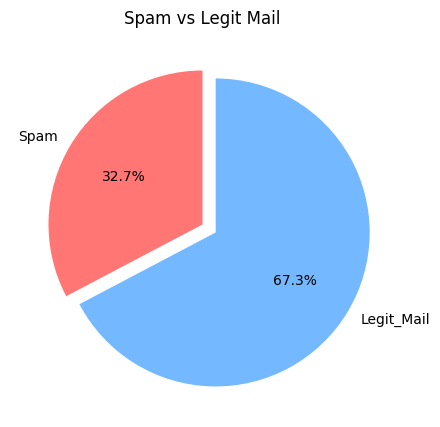

In [32]:
category_names = ['Spam', 'Legit_Mail']
sizes = [amount_of_spam, amount_of_ham]

custom_colors = ['#ff7675','#74b9ff']
plt.figure(figsize=(5, 5), dpi=100)
plt.pie(sizes, labels=category_names, textprops={'fontsize':10},
        startangle=90, autopct='%1.1f%%', colors = custom_colors, explode=[0, 0.1])
plt.title('Spam vs Legit Mail')
plt.show()

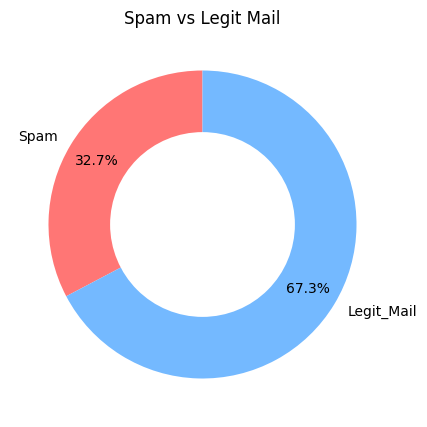

In [33]:
category_names = ['Spam', 'Legit_Mail']
sizes = [amount_of_spam, amount_of_ham]

custom_colors = ['#ff7675','#74b9ff']
plt.figure(figsize=(5, 5), dpi=100)
plt.pie(sizes, labels=category_names, textprops={'fontsize':10},
        startangle=90, autopct='%1.1f%%', colors = custom_colors, pctdistance=0.8)

#draw circle
centre_circle = plt.Circle((0,0), radius=0.6, fc='white')

fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Spam vs Legit Mail')
plt.show()

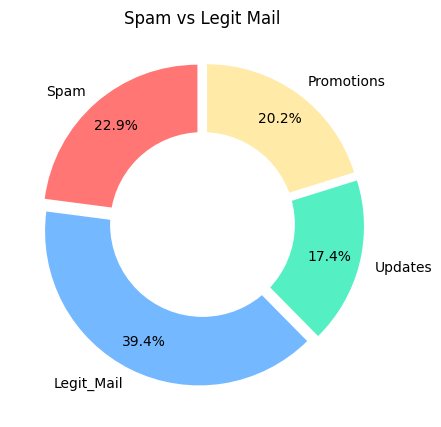

In [34]:
category_names = ['Spam', 'Legit_Mail', 'Updates', 'Promotions']
sizes = [25, 43, 19, 22]
offset = [0.05, 0.05, 0.05, 0.05]

custom_colors = ['#ff7675','#74b9ff', '#55efc4', '#ffeaa7']
plt.figure(figsize=(5, 5), dpi=100)
plt.pie(sizes, labels=category_names, textprops={'fontsize':10},
        startangle=90, autopct='%1.1f%%', colors = custom_colors, pctdistance=0.8, explode=offset)

#draw circle
centre_circle = plt.Circle((0,0), radius=0.6, fc='white')

fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Spam vs Legit Mail')
plt.show()

# **Natural Language Processing**
**Text Pre-Processing**

In [35]:
msg = 'All work and no play makes Jack a dull boy'
msg.lower()

'all work and no play makes jack a dull boy'

**Download the NLTK Resources(Tokenizer & Stopwords)**

In [36]:
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [37]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

**Tokenising**

In [ ]:
msg = 'All work and no play makes Jack a dull boy'
word_tokenize(msg.lower())

['all', 'work', 'and', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy']

**Removing stop words**

In [38]:
stop_words = set(stopwords.words('english'))

In [39]:
if 'this' in stop_words:
  print('True')
else:
  print('Nope.Not in here')

True


In [40]:
msg = 'All work and no play makes Jack a dull boy.To be or not to be that is the question.'
words = word_tokenize(msg.lower())

filtered_words = []
for word in words:
  if word not in stop_words:
    filtered_words.append(word)

print(filtered_words)


['work', 'play', 'makes', 'jack', 'dull', 'boy.to', 'question', '.']


**Word Stems and Stemming**

In [41]:
msg = 'All work and no play makes Jack a dull boy.To be or not to be that is the question. \
Nobody expects Spanish Inquisition'
words = word_tokenize(msg.lower())

#stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')

filtered_words = []

for word in words:
  if word not in stop_words:
    stemmed_word = stemmer.stem(word)
    filtered_words.append(word)

print(filtered_words)


['work', 'play', 'makes', 'jack', 'dull', 'boy.to', 'question', '.', 'nobody', 'expects', 'spanish', 'inquisition']


In [42]:
msg = 'All work and no play makes Jack a dull boy.To be or not to be that is the question.??? \
Nobody expects Spanish Inquisition'
words = word_tokenize(msg.lower())

#stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')
filtered_words = []

for word in words:
  if word not in stop_words and word.isalpha():
    stemmed_word = stemmer.stem(word)
    filtered_words.append(word)

print(filtered_words)


['work', 'play', 'makes', 'jack', 'dull', 'nobody', 'expects', 'spanish', 'inquisition']


**Removing HTML tags from emails**

In [48]:
soup = BeautifulSoup(data.at[2, 'MESSAGE'], 'html.parser')
print(soup.prettify())

Dear Homeowner,

 

Interest Rates are at their lowest point in 40 years!



We help you find the best rate for your situation by

matching your needs with hundreds of lenders!



Home Improvement, Refinance, Second Mortgage,

Home Equity Loans, and More! Even with less than

perfect credit!



This service is 100% FREE to home owners and new

home buyers without any obligation. 



Just fill out a quick, simple form and jump-start

your future plans today!





Visit http://61.145.116.186/user0201/index.asp?Afft=QM10













To unsubscribe, please visit:



http://61.145.116.186/light/watch.asp



In [49]:
soup.get_text()

'Dear Homeowner,\n\n \n\nInterest Rates are at their lowest point in 40 years!\n\n\n\nWe help you find the best rate for your situation by\n\nmatching your needs with hundreds of lenders!\n\n\n\nHome Improvement, Refinance, Second Mortgage,\n\nHome Equity Loans, and More! Even with less than\n\nperfect credit!\n\n\n\nThis service is 100% FREE to home owners and new\n\nhome buyers without any obligation. \n\n\n\nJust fill out a quick, simple form and jump-start\n\nyour future plans today!\n\n\n\n\n\nVisit http://61.145.116.186/user0201/index.asp?Afft=QM10\n\n\n\n\n\n\n\n\n\n\n\n\n\nTo unsubscribe, please visit:\n\n\n\nhttp://61.145.116.186/light/watch.asp\n\n\n\n\n'

**Fuctions for email processing**

In [56]:
def clean_message(message, stemmer=PorterStemmer(),
                  stop_words = set(stopwords.words('english'))):

   words = word_tokenize(message.lower())
   filtered_words = []

   for word in words:
    if word not in stop_words and word.isalpha():
      stemmed_word = stemmer.stem(word)
      filtered_words.append(stemmer.stem(word))


   return filtered_words


In [57]:
clean_message(email_body)

['dear',
 'mr',
 'still',
 'good',
 'tide',
 'staff',
 'festiv',
 'season',
 'ahead',
 'christma',
 'crux',
 'fulli',
 'qualifi',
 'santa',
 'clau',
 'wonder',
 'whether',
 'might',
 'consid',
 'run',
 'santa',
 'grotto',
 'store',
 'wait',
 'probabl',
 'think',
 'make',
 'special',
 'well',
 'first',
 'made',
 'sever',
 'chang',
 'characteris',
 'father',
 'christma',
 'rather',
 'greet',
 'children',
 'shout',
 'ho',
 'ho',
 'ho',
 'prefer',
 'whisper',
 'phrase',
 'depend',
 'unfathom',
 'cruel',
 'world',
 'live',
 'addit',
 'gift',
 'rang',
 'felt',
 'hoop',
 'holder',
 'note',
 'also',
 'enclos',
 'sketch',
 'radic',
 'redesign',
 'santa',
 'outfit',
 'renam',
 'charact',
 'lord',
 'buckl',
 'would',
 'interest',
 'employ',
 'promis',
 'never',
 'let',
 'look',
 'forward',
 'hear',
 'best',
 'wish',
 'robin',
 'cooper',
 'excerpt',
 'book',
 'timewast',
 'letter',
 'robin',
 'cooper']

In [59]:
def clean_msg_no_html(message, stemmer=PorterStemmer(),
                  stop_words = set(stopwords.words('english'))):

   soup = BeautifulSoup(message, 'html.parser')
   cleaned_text = soup.get_text()

   words = word_tokenize(cleaned_text.lower())
   filtered_words = []

   for word in words:
    if word not in stop_words and word.isalpha():
      stemmed_word = stemmer.stem(word)
      filtered_words.append(stemmer.stem(word))


   return filtered_words


In [60]:
clean_msg_no_html(data.at[2, 'MESSAGE'])

['dear',
 'homeown',
 'interest',
 'rate',
 'lowest',
 'point',
 'year',
 'help',
 'find',
 'best',
 'rate',
 'situat',
 'match',
 'need',
 'hundr',
 'lender',
 'home',
 'improv',
 'refin',
 'second',
 'mortgag',
 'home',
 'equiti',
 'loan',
 'even',
 'less',
 'perfect',
 'credit',
 'servic',
 'free',
 'home',
 'owner',
 'new',
 'home',
 'buyer',
 'without',
 'oblig',
 'fill',
 'quick',
 'simpl',
 'form',
 'futur',
 'plan',
 'today',
 'visit',
 'http',
 'unsubscrib',
 'pleas',
 'visit',
 'http']

# **Apply Cleaning and Tokenisation to all messages**

**Slicing dataframes and series & Creating Subsets**

In [62]:
data.iat[2, 2]

'00438.41295e1df4b651b7611316331b8468e4'

In [64]:
data.iloc[5:11]

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5,<html>\n\n\n\n<head>\n\n<title>Home Page</titl...,1,00417.7b196fd20fd308e0afa9032ccb02474b
6,"<html><xbody>\n\n<hr width = ""100%"">\n\n<cente...",1,00217.43b4ef3d9c56cf42be9c37b546a19e78
7,This is a multi-part message in MIME format.\n...,1,00311.9797029f3ee441b00f3b7521e573cb96
8,This is a multi-part message in MIME format.\n...,1,00338.a595ffbb6cbcf3a5058293051ebaabf4
9,=================================\n\n\n\nGuara...,1,00097.013347cc91e7d0915074dccb0428883f
10,This is a multi-part message in MIME format.\n...,1,00265.d2acd28cf29d90c9b7a1297b219187b3


In [68]:
first_emails = data.MESSAGE.iloc[0:3]
nested_list = first_emails.apply(clean_message)

In [71]:
#flat_list = []
#for sublist in nested_list:
#  for item in sublist:
#    flat_list.append(item)

flat_list = [item for sublist in nested_list for item in sublist]

len(flat_list)

529

In [75]:
#use apply() on all the messages in dataframe
nested_list = data.MESSAGE.apply(clean_msg_no_html)

<ipython-input-59-2fcfc54ceef1>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(message, 'html.parser')
<ipython-input-59-2fcfc54ceef1>:4: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(message, 'html.parser')


In [76]:
nested_list.tail()

,MESSAGE
DOC_ID,
5791,"[fri, jul, wynn, conor, wrote, long, look, lik..."
5792,"[hi, suddenli, anymor, click, spell, window, o..."
5793,"[thu, jul, matthia, saou, wrote, upon, time, m..."
5794,"[hi, guy, look, help, one, server, instal, use..."
5795,"[school, push, irish, throat, develop, hatr, i..."
